In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, initializers
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import image_dataset_from_directory,to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import normalize
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score
from keras.models import load_model


In [6]:
input_dir = "G:/oil_spills_detection/Datasets"  # Path to the original dataset
output_dir = "G:/oil_spills_detection/Datagen"  # Directory to save augmented images
validation_dir = "G:/oil_spills_detection/Validation_data"
train_dir= "G:/oil_spills_detection/train_data"

# New Section

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Datagen',
    labels='inferred',           # Automatically assign labels based on folder names
    label_mode='int',            # Use integer labels (0 for class1, 1 for class2)
    image_size=(224, 224),       # Resize images to 224x224
    batch_size=None              # Do not batch, load all images at once
)
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())

# Convert lists to NumPy arrays
images = np.array(images, dtype=np.float32)  # Shape: (total_images, 224, 224, 3)
labels = np.array(labels, dtype=np.int32)    # Shape: (total_images,)



Found 3120 files belonging to 2 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/validation_data',
    labels='inferred',           # Automatically assign labels based on folder names
    label_mode='int',            # Use integer labels (0 for class1, 1 for class2)
    image_size=(224, 224),       # Resize images to 224x224
    batch_size=None              # Do not batch, load all images at once
)
test_images = []
test_labels = []

for image, label in test_dataset:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

# Convert lists to NumPy arrays
test_images = np.array(test_images, dtype=np.float32)  # Shape: (total_images, 224, 224, 3)
test_labels = np.array(test_labels, dtype=np.int32)    # Shape: (total_images,)

print("Images shape:", test_images.shape)
print("Labels shape:", test_labels.shape)



Found 828 files belonging to 2 classes.
Images shape: (828, 224, 224, 3)
Labels shape: (828,)


In [5]:
images = images.astype('float32') / 255
test_images =  test_images.astype('float32') / 255

In [6]:
model = models.Sequential() # create a model with sequential class


model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_initializer= initializers.HeNormal(), kernel_regularizer=l2(0.01))) # output is 256 values
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid', kernel_initializer= initializers.glorot_uniform())) # single dense layer is the final layer, converts values between 0 and 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile('adam', loss= "BinaryCrossentropy", metrics=['accuracy'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist = model.fit(images, labels, batch_size= 64, verbose= 1, epochs=18, validation_data=(test_images, test_labels))


Epoch 1/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - accuracy: 0.6863 - loss: 0.6424 - val_accuracy: 0.6775 - val_loss: 0.6601
Epoch 2/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 350s 7s/step - accuracy: 0.6031 - loss: 0.7085 - val_accuracy: 0.6292 - val_loss: 0.6848
Epoch 3/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.6514 - loss: 0.6755 - val_accuracy: 0.7029 - val_loss: 0.6400
Epoch 4/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.6904 - loss: 0.6446 - val_accuracy: 0.6582 - val_loss: 0.6696
Epoch 5/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.6840 - loss: 0.6331 - val_accuracy: 0.7150 - val_loss: 0.6546
Epoch 6/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.7226 - loss: 0.6497 - val_accuracy: 0.6896 - val_loss: 0.6543
Epoch 7/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - accuracy: 0.7158 - loss: 0.6226 - val_accuracy: 0.7210 - val_loss: 0.6494
Epoch 8/18
49/49 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.7289 - loss: 0.6349 - val_accuracy: 0.7005 - v

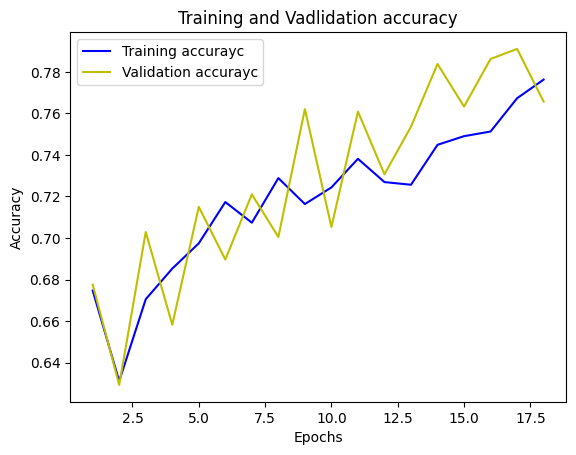

In [10]:
epochs = range(1, len(hist.history['accuracy']) + 1)
acc = hist.history["accuracy"]
val_acc= hist.history['val_accuracy']
plt.plot(epochs, acc, 'b', label= 'Training accurayc')
plt.plot(epochs, val_acc, 'y', label= 'Validation accurayc')
plt.title('Training and Vadlidation accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

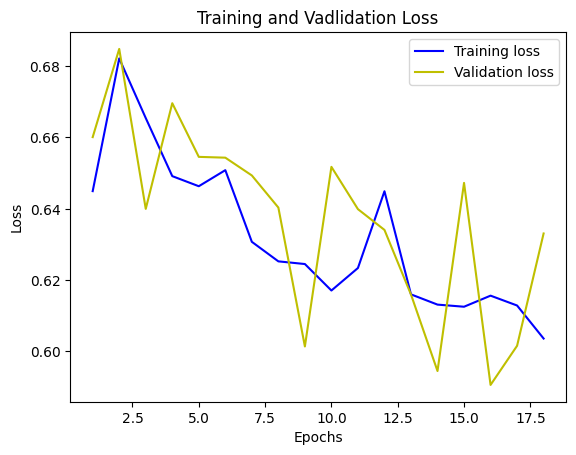

In [11]:
epochs = range(1, len(hist.history['loss']) + 1)
loss = hist.history["loss"]
val_loss= hist.history['val_loss']
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'y', label= 'Validation loss')
plt.title('Training and Vadlidation Loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
The prediction for this image is:  [[0.6079818]]
The actual label for this image is:  1


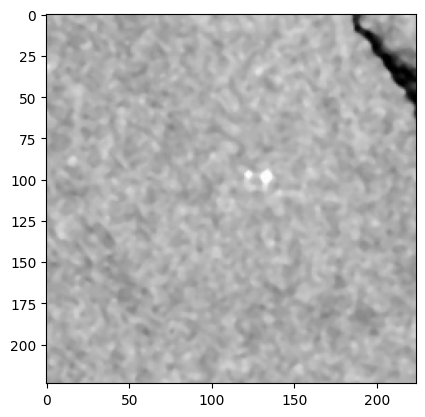

In [43]:
n=25
img = test_images[n]
plt.imshow(img)
input_img = np.expand_dims(img,axis=0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", test_labels[n])

In [16]:
_, acc = model.evaluate(test_images, test_labels)
print("Accuracy= ", (acc*100.0), "%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7794 - loss: 0.6226
Accuracy=  76.57004594802856 %


In [21]:
threshold= 0.347254
y_pred = (model.predict(test_images)>= threshold).astype(int)
cm= confusion_matrix(test_labels, y_pred)
print(cm)
recall_sco = recall_score(test_labels, y_pred)
precision_sco = precision_score(test_labels, y_pred)
f1_sco = f1_score(test_labels, y_pred)
print(recall_sco, precision_sco, f1_sco)

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
[[342 105]
 [ 90 291]]
0.7637795275590551 0.7348484848484849 0.749034749034749


26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step


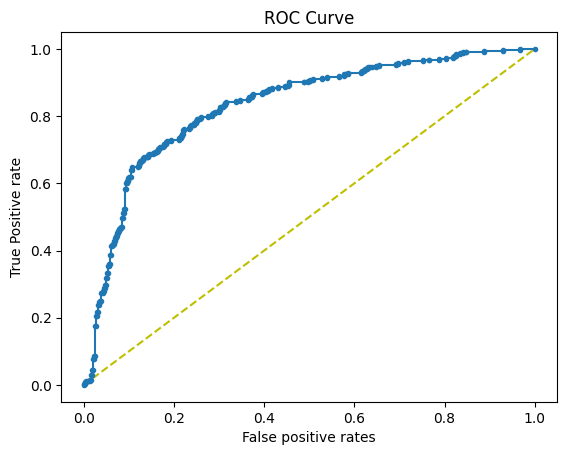

In [34]:
y_preds= model.predict(test_images).ravel()
fpr,tpr, thresholds = roc_curve(test_labels, y_preds)
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr,tpr,marker= '.')
plt.xlabel('False positive rates')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.show()

In [20]:
i= np.arange(len(tpr))
roc= pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index= i), 'thresholds': pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print('Ideal threshold is: ', ideal_roc_thresh['thresholds'])

Ideal threshold is:  142    0.347254
Name: thresholds, dtype: float32


In [23]:
auc_value = auc(fpr, tpr)
print("Area under cureve, AUC = ", auc_value)

Area under cureve, AUC =  0.7644400993499973


In [29]:

model_json = model.to_json()

with open("/content/drive/My Drive/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/model.weights.h5")

In [25]:
from google.colab import files

# Download the saved .h5 file
files.download('model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from google.colab import files

# Download the saved .h5 file
files.download('model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
model.save('/content/drive/My Drive/my_model.h5')

In [30]:

# opening and store file in a variable

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


In [31]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [50]:
# compile and evaluate loaded model
# loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

test1= cv2.imread("/content/drive/MyDrive/Sample images/images (1).jpg")


resized_image = cv2.resize(test1, (224, 224))


test_pred = resized_image.astype('float32') / 255
test_pred = np.expand_dims(test_pred, axis=0)  # Reshape to (1, 224, 224, 3)

predictions = loaded_model.predict(test_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [51]:
if predictions>0.347254:
  print("Oil spill")
else:
  print("No oil spill")


No oil spill
